In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 300

from celerite import plot_setup
plot_setup.setup(auto=False)

## Recovery of a celerite process

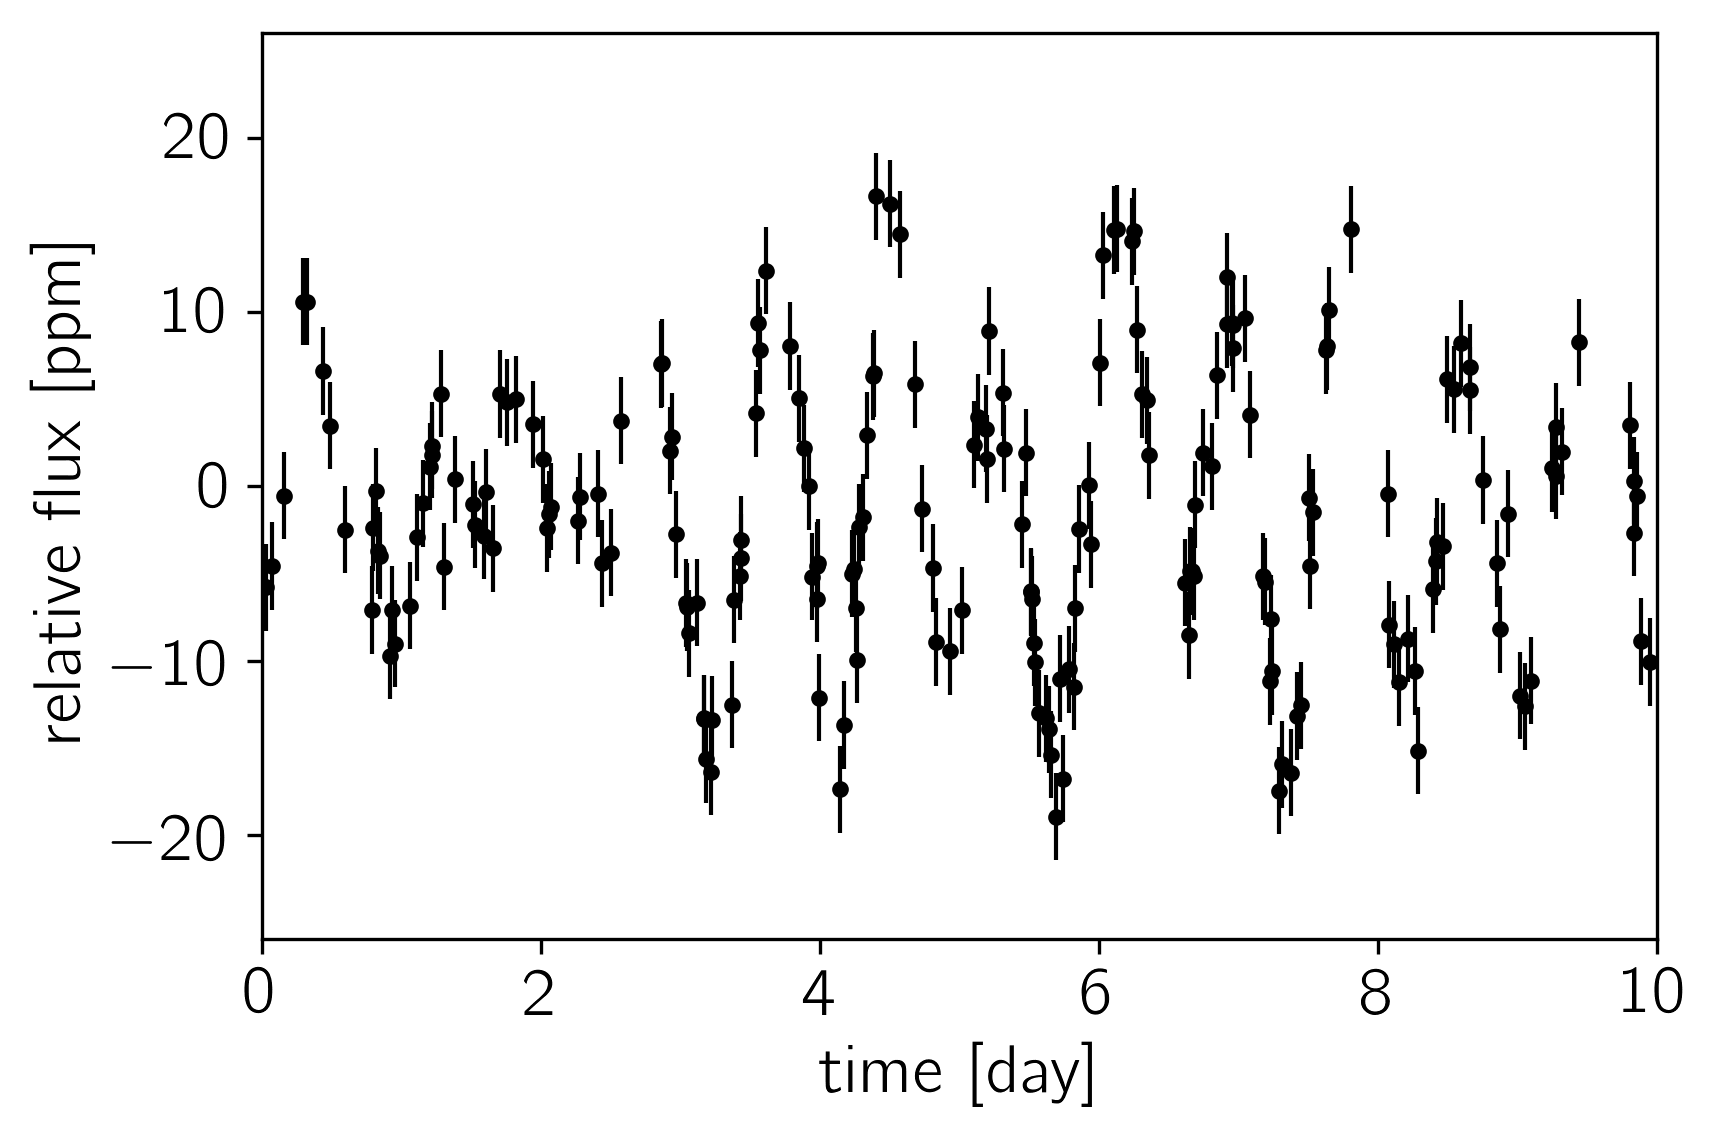

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import celerite
from celerite import terms

np.random.seed(123)

# Simulate some data
kernel = terms.SHOTerm(log_S0=0.0, log_omega0=2.0, log_Q=2.0,
                       bounds=[(-10, 10), (-10, 10), (-10, 10)])
gp = celerite.GP(kernel)
true_params = np.array(gp.get_parameter_vector())
omega = 2*np.pi*np.exp(np.linspace(-np.log(10.0), -np.log(0.1), 5000))
true_psd = gp.kernel.get_psd(omega)
N = 200
t = np.sort(np.random.uniform(0, 10, N))
yerr = 2.5

gp.compute(t, yerr)
y = gp.sample()

fig, ax = plt.subplots(1, 1)
ax.errorbar(t, y, yerr=yerr, fmt=".k", lw=1)
ax.set_ylim(-26, 26)
ax.set_xlim(0, 10)
ax.set_xlabel("time [day]")
ax.set_ylabel("relative flux [ppm]");

In [3]:
import copy
from scipy.optimize import minimize

def nll(params, gp, y):
    gp.set_parameter_vector(params)
    if not np.isfinite(gp.log_prior()):
        return 1e10
    ll = gp.log_likelihood(y)
    return -ll if np.isfinite(ll) else 1e10

p0 = true_params + 1e-4*np.random.randn(len(true_params))
soln = minimize(nll, p0, method="L-BFGS-B", args=(gp, y))
gp.set_parameter_vector(soln.x)
ml_psd = gp.kernel.get_psd(omega)

ml_gp = copy.deepcopy(gp)
ml_gp.log_likelihood(y)

-520.783208068403

In [4]:
import emcee

def log_probability(params):
    gp.set_parameter_vector(params)
    
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf

    ll = gp.log_likelihood(y)
    return ll + lp if np.isfinite(ll) else -np.inf

ndim = len(soln.x)
nwalkers = 32
coords = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
coords, _, _ = sampler.run_mcmc(coords, 500)
sampler.reset()
coords, _, _ = sampler.run_mcmc(coords, 2000)

In [5]:
# Compute the posterior PSD inference
samples = sampler.flatchain[::15, :]
post_psd = np.empty((len(samples), len(omega)))
for i, s in enumerate(samples):
    gp.set_parameter_vector(s)
    post_psd[i] = gp.kernel.get_psd(omega)
q = np.percentile(post_psd, [16, 50, 84], axis=0)

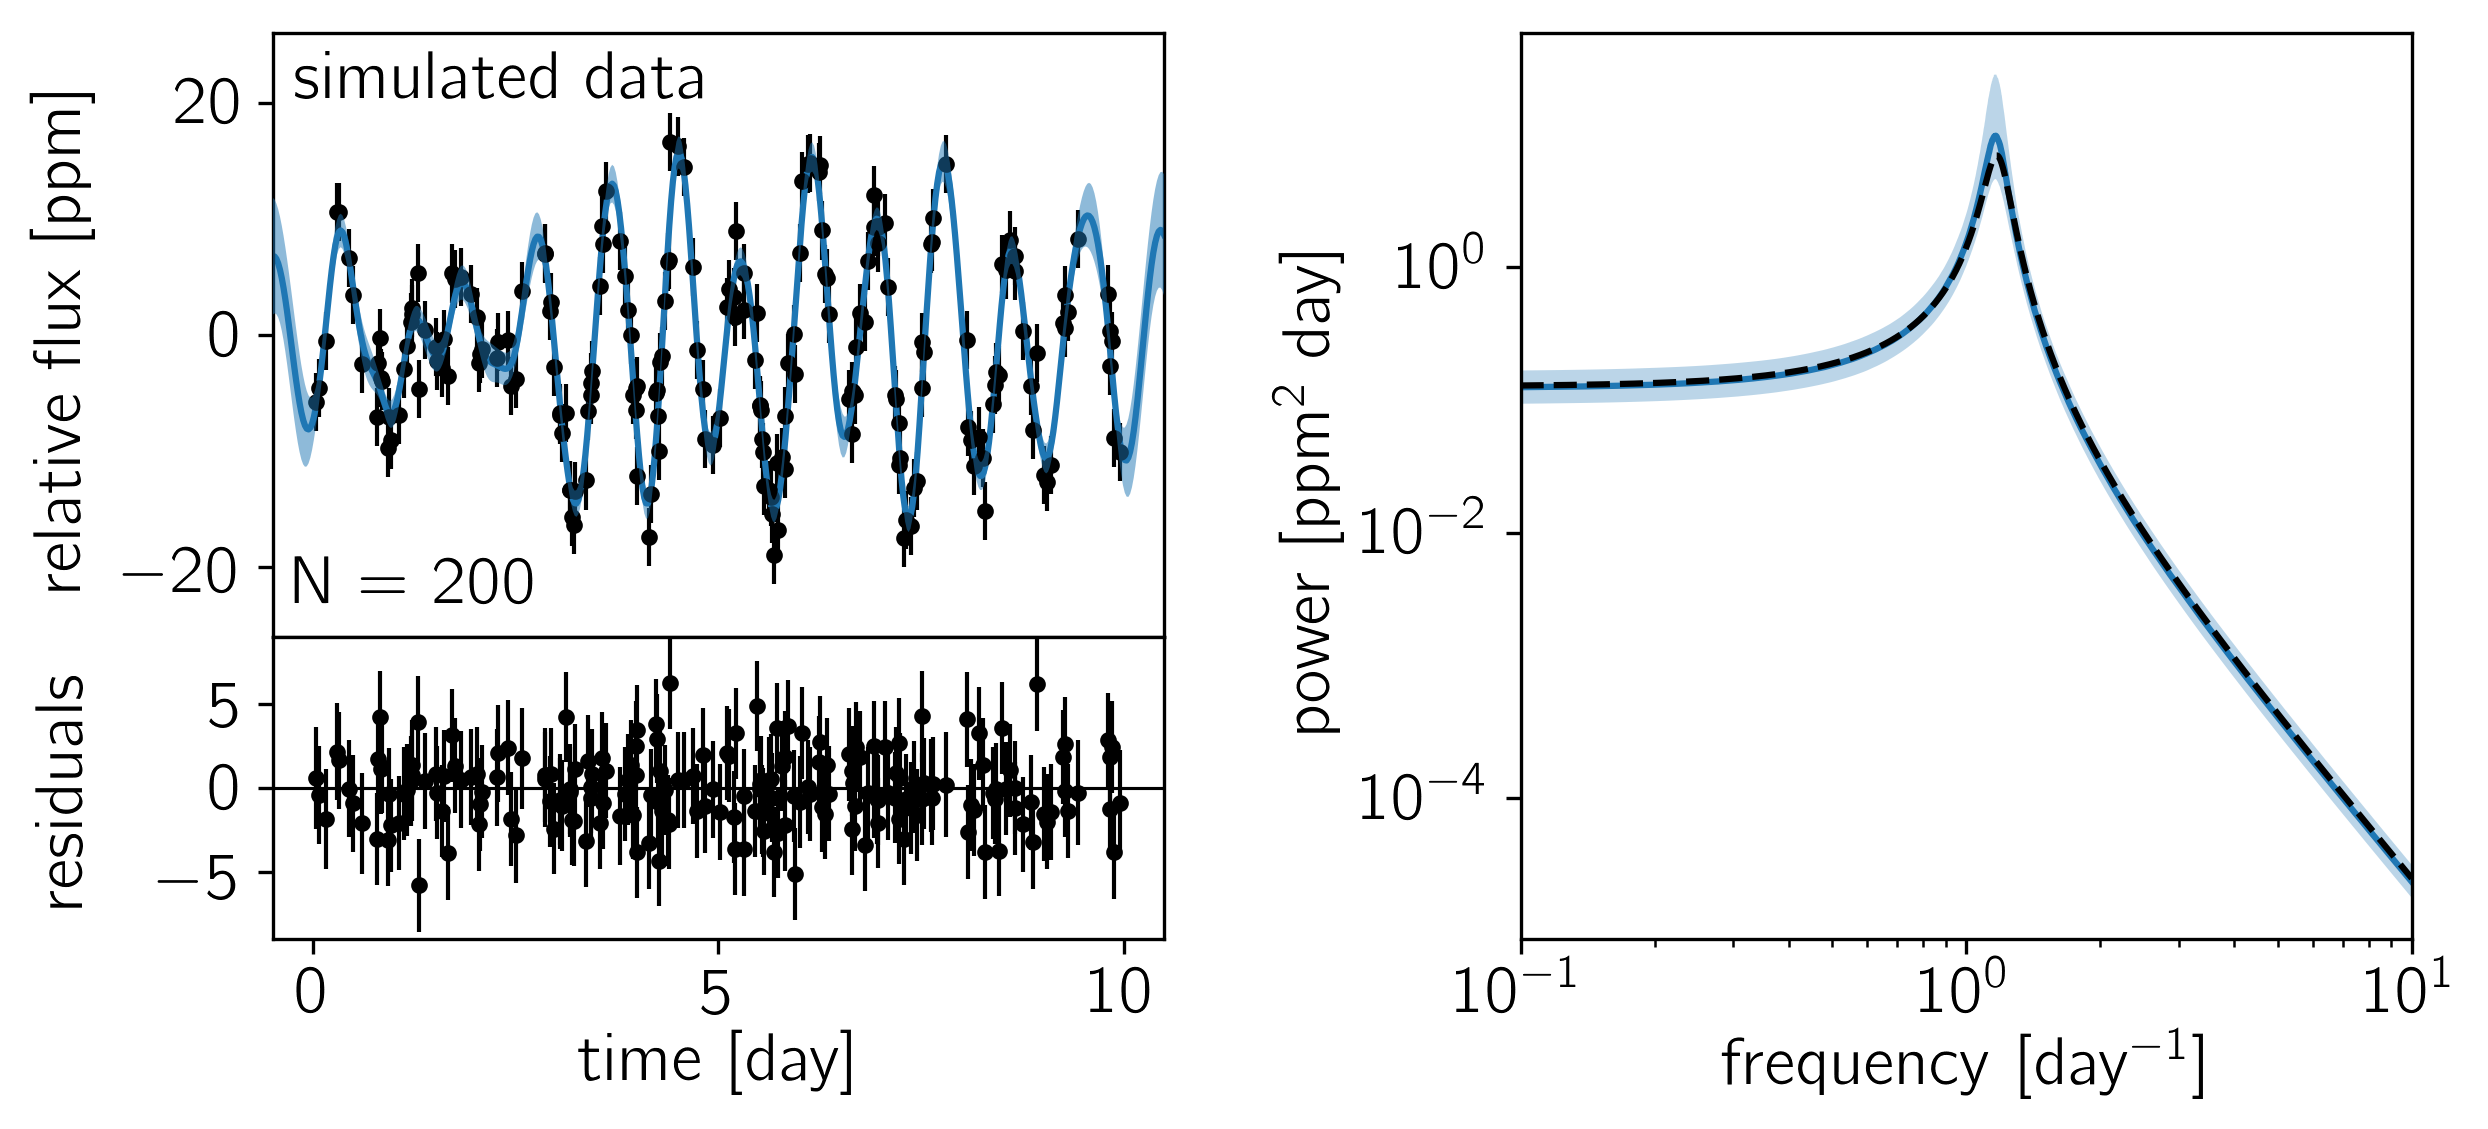

In [19]:
x = np.linspace(-0.5, 10.5, 500)
mu, var = ml_gp.predict(y, x, return_var=True)
std = np.sqrt(var)

fig = plt.figure(figsize=plot_setup.get_figsize(1, 2.3))

ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 2), (2, 0), rowspan=1)
ax3 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
fig.subplots_adjust(hspace=0, wspace=0.4)

ax1.errorbar(t, y, yerr=yerr, fmt=".k", lw=1)
ax1.plot(x, mu)
ax1.fill_between(x, mu+std, mu-std, alpha=0.5, edgecolor="none", zorder=100)
ax1.set_xticklabels([])

ax1.annotate("simulated data", xy=(0, 1), xycoords="axes fraction",
             xytext=(5, -5), textcoords="offset points",
             ha="left", va="top")
ax1.annotate("N = {0}".format(len(t)), xy=(0, 0),
             xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom")

pred_mu, pred_var = ml_gp.predict(y, return_var=True)
std = np.sqrt(yerr**2 + pred_var)
ax2.errorbar(t, y - pred_mu, yerr=std, fmt=".k", lw=1)
ax2.axhline(0.0, color="k", lw=0.75)

ax1.set_ylim(-26, 26)
ax1.set_xlim(-0.5, 10.5)
ax2.set_ylim(-9, 9)
ax2.set_xlim(-0.5, 10.5)

ax2.set_xlabel("time [day]")
ax1.set_ylabel("relative flux [ppm]")
ax2.set_ylabel("residuals")

for ax in [ax1, ax2]:
    ax.yaxis.set_label_coords(-0.2, 0.5)

# plot the PSD comparison
factor = 1.0 / (2*np.pi)
f = omega * factor
ax3.plot(f, q[1] * factor)
ax3.fill_between(f, q[0] * factor, q[2] * factor, alpha=0.3)
ax3.plot(f, true_psd * factor, "--k")
ax3.set_xlim(f[0], f[-1])
ax3.set_yscale("log")
ax3.set_xscale("log")
ax3.set_xlabel("frequency [day$^{-1}$]")
ax3.set_ylabel("power [ppm$^2$ day]")

ax2.xaxis.set_label_coords(0.5, -0.3)
ax3.xaxis.set_label_coords(0.5, -0.1)

fig.savefig("correct.pdf", bbox_inches="tight")

234 µs ± 13.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [45]:
from scipy.linalg import cho_solve, cho_factor

p0 = gp.get_parameter_vector()
fast_timing = %timeit -o log_probability(p0)

def _time_this():
    K = gp.get_matrix(include_diagonal=True)
    factor = cho_factor(K, overwrite_a=True)
    ld = 2.0 * np.sum(np.log(np.diag(factor[0])))
    ll = -0.5*(np.dot(y, cho_solve(factor, y))+ld) + gp.log_prior()

slow_timing = %timeit -o _time_this()

221 µs ± 7.13 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.65 ms ± 450 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
tau = np.mean(sampler.get_autocorr_time(c=3))
neff = len(sampler.flatchain) / tau

In [49]:
import json
with open("correct.json", "w") as f:
    json.dump(dict(
        N=len(t),
        tau=tau,
        neff=neff,
        time=fast_timing.average,
        direct_time=slow_timing.average,
    ), f)